# Random Forest: Bosques

In [1]:
#from pyspark import SparkContext
#sc = SparkContext()
#from pyspark.sql import SQLContext
#sqlContext=SQLContext(sc)

In [2]:
bd5 = sqlContext.read.format(
    "com.databricks.spark.csv"
).option("header", "true").load("bd5.csv", inferSchema=True)
sqlContext.registerDataFrameAsTable(bd5, "bd5")

In [3]:
bd5.dtypes

[('YEAR', 'int'),
 ('MONTH', 'int'),
 ('DAY_OF_MONTH', 'int'),
 ('DAY_OF_WEEK', 'int'),
 ('CRS_DEP_TIME', 'int'),
 ('OP_UNIQUE_CARRIER', 'string'),
 ('TAIL_NUM', 'string'),
 ('ARR_DELAY', 'double'),
 ('DEP_DELAY', 'double'),
 ('ORIGIN', 'string'),
 ('DEST', 'string'),
 ('DISTANCE', 'double'),
 ('CANCELLED', 'double'),
 ('DIVERTED', 'double'),
 ('CARRIER_DELAY', 'double'),
 ('WEATHER_DELAY', 'double'),
 ('NAS_DELAY', 'double'),
 ('SECURITY_DELAY', 'double'),
 ('LATE_AIRCRAFT_DELAY', 'double'),
 ('LogD', 'double'),
 ('Retraso', 'int'),
 ('RetrasoNeto', 'double'),
 ('Horario', 'int')]

In [5]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol='OP_UNIQUE_CARRIER',outputCol='IndexUniqueCarrier') #el índice empieza en el 0!
bd6=indexer.fit(bd5).transform(bd5)

bd6.groupBy('OP_UNIQUE_CARRIER','IndexUniqueCarrier').count().sort('IndexUniqueCarrier').show()


+-----------------+------------------+-----+
|OP_UNIQUE_CARRIER|IndexUniqueCarrier|count|
+-----------------+------------------+-----+
|               AA|               0.0| 8853|
|               UA|               1.0| 6112|
|               WN|               2.0| 5395|
|               DL|               3.0| 4239|
|               VX|               4.0| 1703|
|               NK|               5.0| 1581|
|               F9|               6.0| 1295|
|               OO|               7.0| 1166|
|               B6|               8.0|  121|
|               EV|               9.0|    1|
+-----------------+------------------+-----+



## Regression Random Forest

In [6]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

a1  = VectorAssembler(
    inputCols=['DEP_DELAY','DISTANCE','DAY_OF_WEEK',
               'CRS_DEP_TIME','IndexUniqueCarrier'],
    outputCol='features')

bd7 = a1.transform(bd6).select(col("ARR_DELAY").alias("label"),'features')

## Partición Test - Train

In [7]:
(bd_train, bd_test) = bd7.randomSplit([0.7, 0.3],seed=123)
print(bd_train.count())
print(bd_test.count())

21278
9188


In [8]:
from pyspark.ml.regression import RandomForestRegressor
from time import time

start_time = time()

# Train a RandomForest model.
rf = RandomForestRegressor(labelCol="label", 
     featuresCol="features", 
     numTrees=500,
     maxDepth=5,
     seed = 1,
     subsamplingRate=1.0,
     featureSubsetStrategy="auto")
     
model = rf.fit(bd_train)

end_time = time()
elapsed_time = end_time - start_time
print("Time to train model: %.3f seconds" % elapsed_time)

pred = model.transform(bd_train)

Time to train model: 26.190 seconds


In [9]:
pred.select('label','prediction').show()

+-----+--------------------+
|label|          prediction|
+-----+--------------------+
|-53.0|-0.01852378745273549|
|-48.0| -3.5402990884487666|
|-48.0|  -5.652301846500719|
|-48.0|  -7.698597537875928|
|-47.0|  1.2425699347973582|
|-46.0|  3.7581030885124074|
|-46.0|  2.0322216548060625|
|-46.0|  -7.138596284923306|
|-46.0|  -4.196239535112512|
|-46.0|  -7.760721970548488|
|-44.0|  1.0920410866454207|
|-44.0| 0.22660581505914854|
|-44.0|  -7.610972566071329|
|-44.0|   4.467259059274749|
|-44.0|-0.12493747726818692|
|-44.0|   1.224551180046195|
|-43.0|   4.714052974810402|
|-43.0|  -5.291012174842159|
|-43.0| -0.6892407459025099|
|-42.0|   -5.05883709799669|
+-----+--------------------+
only showing top 20 rows



In [10]:
from pyspark.ml.evaluation import RegressionEvaluator

print(RegressionEvaluator(metricName="r2").evaluate(pred))

0.6215888540115793


In [11]:
pred2 = model.transform(bd_test)
print(RegressionEvaluator(metricName="r2").evaluate(pred2))

0.6664914093883155


In [12]:
# RandomForestRegressor(featuresCol="features", 
#    labelCol="label",
#    predictionCol="prediction",
#    maxDepth=5,
#    maxBins=32,
#    minInstancesPerNode=1,
#    minInfoGain=0.0,
#    maxMemoryInMB=256, 
#    impurity="variance", 
#    subsamplingRate=1.0, 
#    seed=None, 
#    numTrees=20,
#    featureSubsetStrategy="auto"  / "sqrt" / "onethird" / "log2" / "all")

## Classification Random Forest

In [13]:
from pyspark.ml.feature import VectorAssembler, StringIndexer

a1  = VectorAssembler(
    inputCols=['DEP_DELAY','DISTANCE','DAY_OF_WEEK',
               'CRS_DEP_TIME','IndexUniqueCarrier'],
    outputCol='features')

bd7 = a1.transform(bd6).select(col("Retraso").cast('double').alias("label"),'features')

stringIndexer = StringIndexer(inputCol = 'label', outputCol = 'indexed')
sI = stringIndexer.fit(bd7)
bd7 = sI.transform(bd7)

In [14]:
(bd_train, bd_test) = bd7.randomSplit([0.7, 0.3],seed=123)
print(bd_train.count())
print(bd_test.count())

21278
9188


In [15]:
from pyspark.ml.classification import RandomForestClassifier

start_time = time()

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexed", 
     featuresCol="features", 
     numTrees=500,
     maxDepth=3, 
     seed = 1,
     featureSubsetStrategy="sqrt",
     impurity='gini') 

model = rf.fit(bd_train)

end_time = time()
elapsed_time = end_time - start_time
print("Time to train model: %.3f seconds" % elapsed_time)

pred = model.transform(bd_train)


Time to train model: 10.334 seconds


In [16]:
pred.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [17]:
pred.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 4248|
|  0.0|       0.0|14963|
|  0.0|       1.0|  423|
|  1.0|       0.0| 1644|
+-----+----------+-----+



### Curva ROC


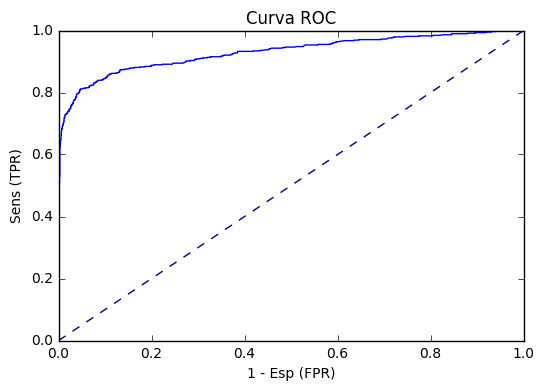

In [18]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

secondelement=udf(lambda v:float(v[1]),FloatType())
pred2=pred.withColumn('probs',secondelement('probability'))


#Dibujamos la curva ROC

pd5 = pred2.sample(False,0.1).select('label','probs').toPandas()
fpr, tpr, _ = roc_curve( pd5['label'], pd5['probs'])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('1 - Esp (FPR)')
plt.ylabel('Sens (TPR)')
plt.title('Curva ROC')
plt.show()

In [19]:
pred2.show()

+-----+--------------------+-------+--------------------+--------------------+----------+-----------+
|label|            features|indexed|       rawPrediction|         probability|prediction|      probs|
+-----+--------------------+-------+--------------------+--------------------+----------+-----------+
|  0.0|[-20.0,602.0,3.0,...|    0.0|[460.383174383508...|[0.92076634876701...|       0.0|0.079233654|
|  0.0|[-16.0,641.0,1.0,...|    0.0|[448.894688702618...|[0.89778937740523...|       0.0|0.102210626|
|  0.0|[-16.0,641.0,6.0,...|    0.0|[447.486863775704...|[0.89497372755140...|       0.0|0.105026275|
|  0.0|[-16.0,868.0,6.0,...|    0.0|[461.374714684961...|[0.92274942936992...|       0.0| 0.07725057|
|  0.0|[-16.0,888.0,3.0,...|    0.0|[445.194887419026...|[0.89038977483805...|       0.0| 0.10961022|
|  0.0|[-15.0,731.0,1.0,...|    0.0|[448.894688702618...|[0.89778937740523...|       0.0|0.102210626|
|  0.0|[-15.0,888.0,4.0,...|    0.0|[445.194887419026...|[0.89038977483805...|    

In [20]:
predtest = model.transform(bd_test)

from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE
print('AUC=',BCE(metricName="areaUnderROC",rawPredictionCol = 'probability').evaluate(pred))
print('AUC=',BCE(metricName="areaUnderROC",rawPredictionCol = 'probability').evaluate(predtest))


AUC= 0.9179488064505984
AUC= 0.9139069107165663
